In [2]:
import numpy as np
import pandas as pd
from os.path import join
import os
from pylab import rcParams
import matplotlib.pyplot as plt

import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM, Hart85
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 11 days


In [3]:
import sys

In [4]:
sys.path.append("../common")
sys.path.append("../../common")
sys.path.append("../../../common")



%matplotlib inline

In [5]:
sys.path.append("../../code/common")

In [6]:
paths = {"Hart": "../../data/hvac/minutes_N2_K3_T50_Hart.csv",
        "CO":"../../data/hvac/minutes_N2_K3_T50_CO.csv",
        "FHMM":"../../data/hvac/minutes_N2_K3_T50_FHMM.csv",
        "Submetered":"../../data/hvac/minutes_GT.csv"}

In [7]:

dfs = {}
for algo, algo_csv in paths.iteritems():
    dfs[algo] = pd.read_csv(algo_csv)
    dfs[algo].index = dfs[algo].dataid
    dfs[algo] = dfs[algo].dropna()
ix = dfs["Submetered"].index

for algo, algo_df in dfs.iteritems():
    ix = algo_df.index.intersection(ix)

a_1 = {}
a_3 = {}
evening_energy = {}
morning_mins = {}
night_mins = {}
for algo, algo_df in dfs.iteritems():
    a_1[algo] = algo_df.ix[ix]["a1"]
    evening_energy[algo] = algo_df.ix[ix]["evening_energy"]
    a_3[algo] = algo_df.ix[ix]["a3"]
    morning_mins[algo] = algo_df.ix[ix]["morning_mins"]
    night_mins[algo] = algo_df.ix[ix]["sleep_mins"]
    
    

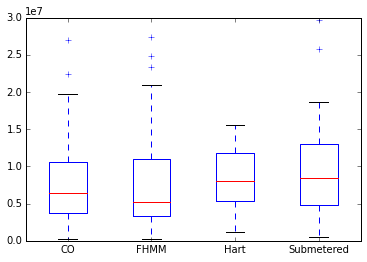

In [8]:
pd.DataFrame(evening_energy).plot(kind="box")

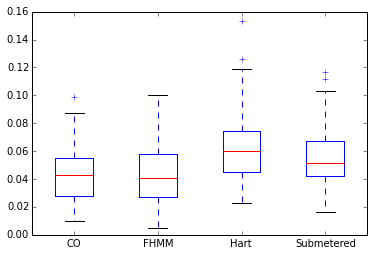

In [9]:
pd.DataFrame(a_1).plot(kind="box")

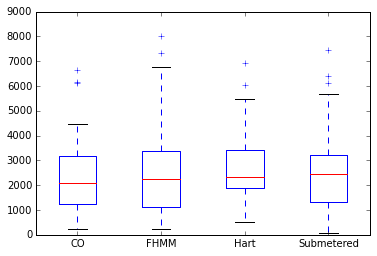

In [10]:
pd.DataFrame(morning_mins).plot(kind="box")

In [11]:
morning_df = pd.DataFrame(morning_mins)
evening_energy = pd.DataFrame(evening_energy)

In [12]:
morning_df.describe()

,CO,FHMM,Hart,Submetered
count,58.000000,58.000000,58.000000,58.000000
mean,2272.482759,2489.862069,2692.362069,2531.982759
std,1428.550673,1793.358561,1334.266152,1580.915818
min,238.000000,228.000000,525.000000,77.000000
25%,1259.250000,1110.500000,1884.500000,1332.750000
50%,2074.000000,2258.000000,2342.000000,2451.500000
75%,3162.250000,3398.500000,3409.000000,3205.750000
max,6642.000000,8005.000000,6923.000000,7458.000000


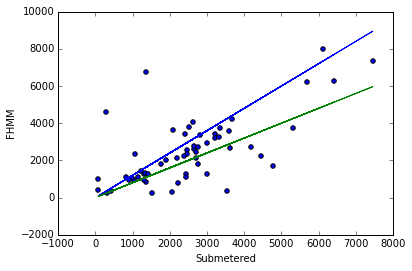

In [13]:
morning_df.plot(kind="scatter",x="Submetered",y="FHMM")
x_line = morning_df["Submetered"]
plt.plot(x_line, 1.2*x_line)
plt.plot(x_line, 0.8*x_line)

In [14]:
Wm_to_kwh = 1.66666667 * 1e-5
def wm_to_kwh_per_month(wm, mins=24*30*60):
    return wm * Wm_to_kwh / (mins * 1.0 / (1440 * 30))

evening_energy = pd.DataFrame(evening_energy).apply(wm_to_kwh_per_month)


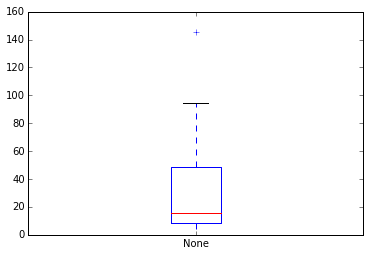

In [15]:
(evening_energy["FHMM"] - evening_energy["Submetered"]).abs().div(evening_energy["Submetered"]).mul(100).plot(kind="box")
#x_line = evening_energy["Submetered"]
#plt.plot(x_line, 1.2*x_line)
#plt.plot(x_line, 0.8*x_line)

In [16]:
out = {"CO":{}, "FHMM":{},"Hart":{}}
for algo in ["CO", "FHMM", "Hart"]:
    out[algo]["Morning"] = (morning_mins[algo] - morning_mins["Submetered"]).abs().div(morning_mins["Submetered"]).mul(100).median()
    out[algo]["Night"] = (night_mins[algo] - night_mins["Submetered"]).abs().div(night_mins["Submetered"]).mul(100).median()
#plt.ylim((0,200))
#x_line = evening_energy["Submetered"]
#plt.plot(x_line, 1.2*x_line)
#plt.plot(x_line, 0.8*x_line)

In [17]:

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [18]:
from common_functions import latexify, format_axes

In [23]:
latexify(fig_height=1.2)

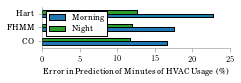

In [24]:
ax = pd.DataFrame(out).T.plot(kind="barh",rot=0, colors=[tableau20[0], tableau20[4]])
format_axes(ax)
#plt.xlabel(r"Mean absolute error")
plt.xlabel("Error in Prediction of Minutes of HVAC Usage (\%)")
#plt.xlabel("$\\frac{|Submetered\,mins-Predicted\,mins| \\times 100 \%}{Submetered\,\,mins}$")
plt.legend(loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/nilm-actionable/figures/hvac/mins.pdf", bbox_inches="tight")

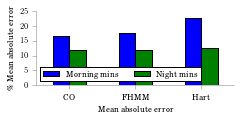

In [52]:
latexify(fig_height=1.7)
ax = pd.DataFrame(out).T.plot(kind="bar",rot=0)
format_axes(ax)
plt.xlabel(r"Mean absolute error")
plt.ylabel("\% Mean absolute error")
plt.legend(loc=3, ncol=2)
plt.tight_layout()

In [74]:
(night_mins["CO"] - night_mins["Submetered"]).abs().div(night_mins["Submetered"]).mul(100).describe()



count     58.000000
mean      26.223560
std       33.541426
min        0.013240
25%        3.693213
50%       11.737220
75%       35.355011
max      151.521859
Name: sleep_mins, dtype: float64

In [56]:
from common_functions import latexify, format_axes

In [25]:
latexify(fig_height=1.2)
ax = pd.DataFrame(baseline_percent).plot(kind="box", color="gray",sym='');
format_axes(plt.gca())
plt.ylabel("Baseline duty\n percentage")
plt.grid(False)
plt.savefig("/Users/nipunbatra/git/nilm-actionable/figures/fridge/baseline_duty_percent.pdf", bbox_inches="tight")


NameError: name 'baseline_percent' is not defined

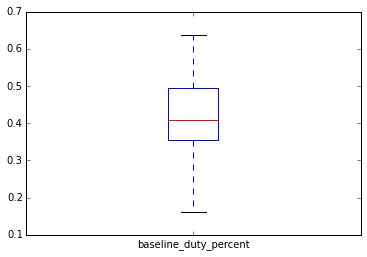

In [16]:
df.baseline_duty_percent.plot(kind="box")